# Running error mitigated many-body physics experiments with TEM function

This collection of exercised is based on the following reference - [ArXiv: Kicked Ising](https://arxiv.org/abs/2411.00765). This reference discusses a real simulation quantum hardware of up to 91 qubits. In this lab, you are going to recreate a similar simulation on a smaller circuit size.

The kicked Ising model corresponds to the usual Ising model: $$ \hat{H}_{\text{I}} = J \sum_{n=0}^{N-2} \hat{Z}_n \hat{Z}_{n+1} + h \sum_{n=0}^{N-1} \hat{Z}_n $$
 to which is applied a transverse kick: $$ \hat{H}_{K} = b \sum_{n=0}^{N-1} \hat{X}_n $$

# Table of Contents

* [Part 1: Run on local simulation](#part-1-run-on-local-simulation)
* [Part 2: Run on real devices](#part-2-run-on-real-devices)

# Setup


In [ ]:
# Install dependencies
%pip install "qiskit[visualization]" qiskit-aer qiskit-ibm-catalog

In [ ]:
# Imports
from matplotlib import pyplot as plt
import numpy as np

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_aer import AerSimulator
from qiskit_ibm_catalog import QiskitFunctionsCatalog
from qiskit_ibm_runtime import EstimatorV2, QiskitRuntimeService

from TEM_lab_validation import check_circuit, validation # These are the grading functions to test inputs

<div class="alert alert-block alert-warning">

**Exclusive Access to Qiskit Functions**

As part of Qiskit Global Summer School (QGSS), participants with a Premium or Flex Plan have limited-time trial access to Qiskit Functions. Access is exclusive and subject to your organization’s administrator approval. Complete [this form](https://airtable.com/appj8IrSNZGz4l4BB/pag8WgWdUr5uSJGZA/form) to request access.

If you encounter the error `QiskitServerlessException: Credentials couldn't be verified`. in the cell below, it means your access to Qiskit Functions is not yet active. Please check back later after your request has been processed.

**Note: Running this lab will consume QPU time from your organization’s account. Estimated QPU usage is provided before each cell that executes on a QPU. Please monitor your usage and consult your organization admin if you’re unsure about your allocated QPU time for QGSS Functions labs.**

</div>

In [ ]:
# Load the Qiskit Functions Catalog
your_api_key = "deleteThisAndPasteYourAPIKeyHere"
your_crn = "deleteThisAndPasteYourCRNHere"

catalog = QiskitFunctionsCatalog(
    channel="ibm_quantum_platform",
    token=your_api_key,
    instance=your_crn,
)
# You should see a list of Qiskit Functions available to you
# If you encounter the error `QiskitServerlessException: Credentials couldn't be verified`,
# it means your access is not yet active
catalog.list()

In [ ]:
# Load Algorithmiq TEM function
tem = catalog.load("algorithmiq/tem")

# Part 1: Run on local simulation

The goal of the notebook is to simulate the dynamic of a state under the transverse kicked Ising Hamiltonian, whose time evolution can be implemented by a Floquet unitary $\hat{U}_{\text{KI}} = e^{-i \hat{H}_K} e^{-i \hat{H}_I} $. 

The build of this unitary is implemented in the next cell. The circuit starts with a state preparation phase, in which the first qubit of the line is in the state $|+\rangle$, while the other states are in the Bell state $(|00\rangle + |11\rangle)/\sqrt{2}$. This is followed by a brickwork structure of 2-qubit blocks which are decomposed in a few single qubit gates (depending on $h$ and $b$ and a repeated $ZZ$ interaction with coupling $J$).

<a id="task1"></a>
<div class="alert alert-block alert-success">
    
<b> Task 1:</b>   
Write a function that returns the desired circuit for a given number of qubits `n_qubits` and a given number of timesteps `t_steps` (with parameters `h`, `b` and `J`).

</div>

In [ ]:
def kicked_ising_circuit(n_qubits, t_steps, J, b, h):
    ki_circuit = QuantumCircuit(n_qubits)

    # State preparation
    # Hadamard gates on first qubit
    ki_circuit.h(0)

    # Further Hadamard gates on odd qubits and
    # Cnot gates between odd(control) and even(target) qubits, leaving out the 0th
    for i in range(1, n_qubits - 1, 2):
        ki_circuit.h(i)
        ki_circuit.cx(i, i + 1)

    ki_circuit.barrier()
    ### Write your code below here ###

    # Time steps (t)
    # Apply the kicked Ising model gates
    # if t%2=0:
    #   Rz(h) on odd qubits
    #   Rzz(2J) between even(i) and odd(i+1) qubits
    #   Rx(2b) on all qubits
    #   Rzz(2J) between even(i) and odd(i+1) qubits
    #   Rz(h) on odd qubits
    #   barrier on all qubits
    # if t%2=1:
    #   Rz(h) on even qubits (skipping the 0th)
    #   Rzz(2J) between odd(i) and even(i+1) qubits
    #   Rx(2b) on all qubits (skipping the 0th)
    #   Rzz(2J) between odd(i) and even(i+1) qubits
    #   Rz(h) on even qubits (skipping the 0th)
    #   barrier on all qubits
    # Note: The first qubit (0th) is not involved when t is odd.

    
    return ki_circuit

Let's visualize the expected output:
`kicked_ising_circuit(11, 5, J=np.pi / 4, b=np.pi / 4, h=0.0).draw("mpl")`

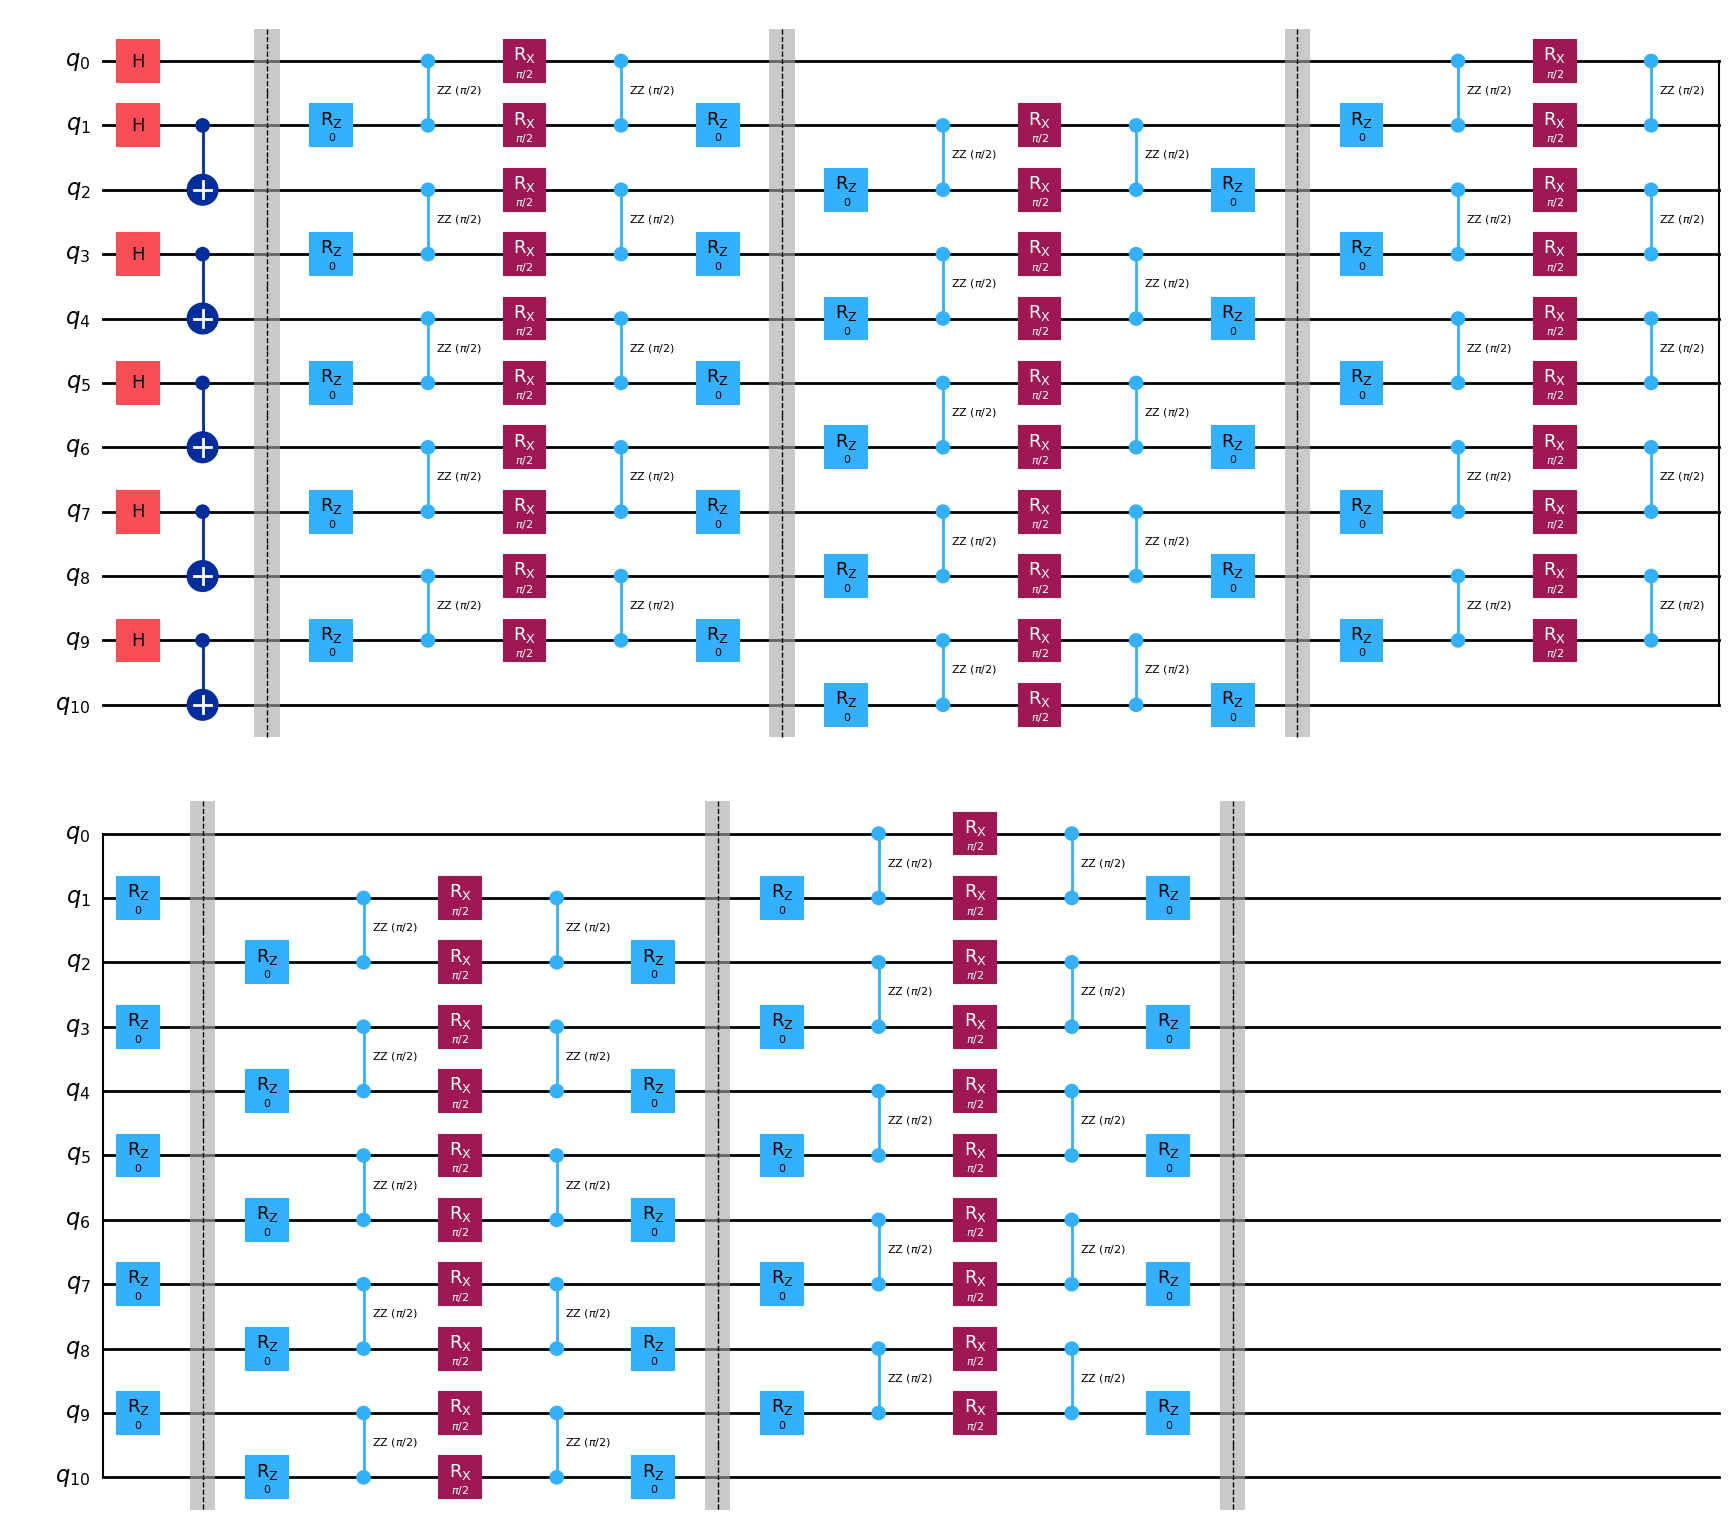

And now try to replicate the same plot:

In [ ]:
kicked_ising_circuit(11, 5, J=np.pi / 4, b=np.pi / 4, h=0.0).draw("mpl") # Expected result type: QuantumCircuit

<a id="task2"></a>
<div class="alert alert-block alert-success">
    
<b> Task 2:</b> 

The quantity we want to observe is the correlation function. The [reference paper](https://arxiv.org/abs/2411.00765) discusses how this quantity can be rewritten as just an $X$ Pauli operator on the $n-th$ qubit. Furthermore, at a given time-step T, the $\langle\psi|X|\psi\rangle$ is equal to one only at the T-th qubit, and zero otherwise.

In Qiskit one can define observables using the `SparsePauliOp` class. Write a function that returns the right observable to measure for `n_qubit`s if we want to check the correlation function on qubit `n`. 

</div>
<a id="tips"></a>
<div class="alert alert-block alert-warning">
    
<b> Warnings:</b> 
Qiskit uses a reversed ordering of the qubits, i.e. qubit 0 is the rightmost in a string
</div>


In [ ]:
estimator = StatevectorEstimator()
num_qubits = 5
n_time_steps = 2
circ = kicked_ising_circuit(num_qubits, n_time_steps, np.pi / 4, np.pi / 4, 0.0)

### Write your code below here ###

paulis_string = "" # TODO: Replace with the correct Pauli string

### Don't change any code past this line ###

obs = SparsePauliOp(paulis_string)
exact = estimator.run([(circ, [obs])]).result()[0].data.evs
print(f"Exact expectation value: {exact[0]}")
assert np.isclose(exact[0], 1, atol=1e-5)

<a id="task3"></a>
<div class="alert alert-block alert-success">
    
<b> Task 3:</b> 
We have seen how to check the correctness of the observable via statevector simulation, it's now time to estimate the correlation function.

In qiskit, the expectation value of observables on a given circuit can be estimated using the [EstimatorV2 primitive](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2). To run the estimation locally you can check [this guide](https://docs.quantum.ibm.com/guides/local-testing-mode#aersimulator-examples)

Let's start with a Clifford circuit, (we set $J = b = \pi/4$, $h=0$). One should be able to observe that $C_n(T) = \delta_{n,T}$, i.e. the correlation function after $T$ time steps, is exactly $1$ for qubit $T$ and zero otherwise.

Check the documentation and try to estimate the correlation function for different qubits at a fixed time step. Let's say `n_qubits = 10` and `T = 3` for example.

</div>

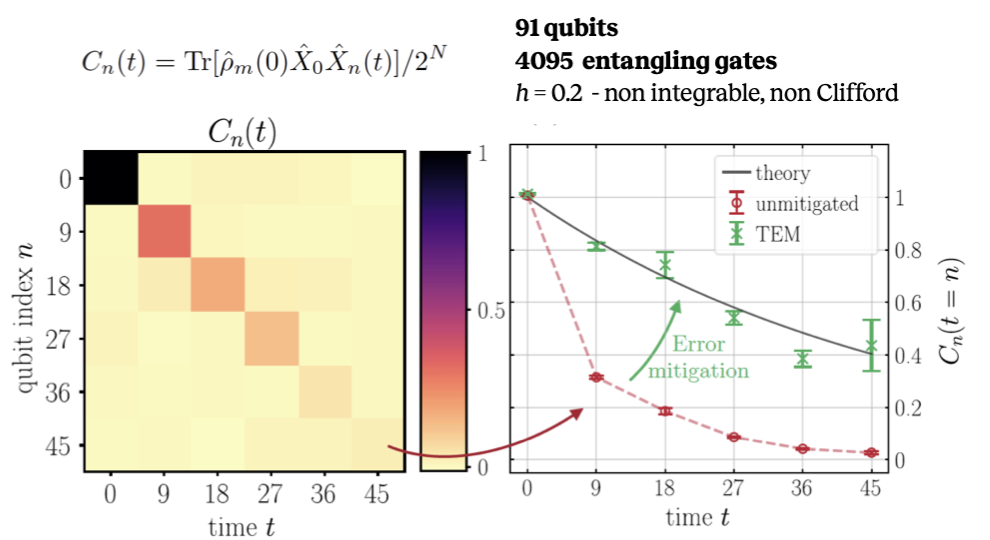

<div class="alert alert-block alert-success">

The goal of this task is to replicate the previous image (left) for a smaller number of qubits, say 10. For this, you should measure X on each qubit $i$ and check its expectation value to be in line with $\delta_{i,T}$. Try simulating it first with a statevector simulator using `StatevectorEstimator` and then with the `AerSimulator` using `EstimatorV2`.
</div>


In [ ]:
num_qubits = 10
time_steps = 3
circ = kicked_ising_circuit(num_qubits, time_steps, np.pi / 4, np.pi / 4, 0.0)
sv_estimator = StatevectorEstimator()
aer_sim = AerSimulator()
estimator = EstimatorV2(mode=aer_sim)

### Write your code below here ###

observables = [ 

] # TODO: Build an array of "X_i" operators for each qubit

# TODO: Make use of sv_estimator
sv_job = 
sv_evs = 

# TODO: Now use the aer_sim and estimator
aer_result = 
aer_evs = 

### Don't change any code past this line ###

print("Statevector expectation values:", sv_evs)
print("Expectation value:", aer_evs)

Let's check that the circuit follows the expected structure:

In [ ]:
### Don't change any code in this cell ###
check_circuit(circ)

<a id="task4"></a>
<div class="alert alert-block alert-success">
    
<b> Task 4: Execute different timesteps</b> 

You can now try and reproduce the image reported above. Since this would require considerable QPU time, we can reproduce the image just by running a simulation. The next part of the exercise will show how to use TEM function on part of the observables that go into this image, thus an extension will be easier to write if needed.

Using Task 3 as reference, you will have to implement a total of `num_qubits` layers with an increasing number of timesteps (`0, 1, ... , num_qubits-1`). For each layer, you should define a kicked Ising circuit with the chosen and fixed `num_qubits` and the corresponding incremental number of timesteps (you can use the utility from Task 1). For each layer, you should also provide a list of operators that implement the X observable for each qubit separately at each timestep (you can use the observables variable defined in Task 3). The output for each layer should be a pub (`(circuit, observables)` tuple) that is appended to `multiple_pubs`. This pub will then be used to call `estimator.run` and get a series of expectation values. Plotting the results should reveal a diagonal.

</div>

In [ ]:
multiple_pubs = []

### Write your code below here ###

for n in range(num_qubits):
# TODO: create num_qubits different circuits with incremental layers,
# all measuring the same observables and place them together in a PUB,
# append pub to multiple_pubs

# TODO: run EstimatorV2
aer_sim = 
estimator =
job = 

### Don't change any code past this line ###

aer_result = job.result()
aer_evs = np.transpose(np.array([np.array(i.data.evs) for i in aer_result]))
print("Expectation value:", aer_evs)


In [ ]:
### Don't change any code in this cell ###
plt.imshow(aer_evs, aspect="auto", cmap="viridis")
plt.colorbar(label="Expectation Value")
plt.ylabel("Index")
plt.xlabel("Time Steps")
plt.title("Expectation Values Over Time Steps")
plt.yticks(ticks=np.arange(num_qubits), labels=[f"Q{i}" for i in range(num_qubits)])
plt.xticks(
    ticks=np.arange(len(aer_evs)), labels=[f"T{i + 1}" for i in range(len(aer_evs))]
)
plt.show()

# Part 2: Run on real devices

Once you have verified that everything works on local simulation, you are ready to run on a real backend. 


<a id="task5"></a>
<div class="alert alert-block alert-success">
    
<b> Task 5: Select backend and transpile</b> 


The first step is *transpiling* the circuit so that it is decomposed in the right set of gates (the IBM Quantum documentation refers to it as ISA).

This can be achieved quite simply with `generate_preset_pass_manager`. [Documentation](https://docs.quantum.ibm.com/api/qiskit/0.42/qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager).


The first step is to select an backend from the available devices. 

<a id="tips"></a>
<div class="alert alert-block alert-warning">
    
<b> Warnings:</b> 
Please keep in mind that the TEM algorithm currently supports only Heron QPUs, **do not select Eagle QPUs**.

</div>

In [ ]:
service = QiskitRuntimeService(
    channel="ibm_quantum_platform",
    token=your_api_key,
    instance=your_crn)
backend_name = "ibm_kingston" # TODO: Replace with your desired backend name
backend = service.backend(backend_name)

For a 10-qubit, 3-step circuit, mantaining the parameters to obtain the clifford circuit that have been used so far, the TEM function should use about **5 minutes of QPU time**.

#### Transpile for the backend

During transpilatio,n it helps to ask to the transpiler to take into account *readout* error of the qubits. This can be obtained by adding a dummy measurement round to the ideal circuit, which can then be removed after transpilation.  

<a id="tips"></a>
<div class="alert alert-block alert-info">
    
<b> Tips:</b> 
Use the `.apply_layout` method.

In [ ]:
transpiler = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=42
)
circ.measure_all() # dummy measurement
circuit_isa = transpiler.run(circ)
circ.remove_final_measurements() # removal of dummy measurement
circuit_isa.remove_final_measurements() # removal of dummy measurement

### Write your code below here ###

observable_isa = [

] # TODO: Observable now must be defined on the whole QPU

Lets inspect the layers resulting from the transpilation, as these are determinant for the TEM algorithm.

In [ ]:
### Don't change any code in this cell ###
# Draw the ISA circuit
circuit_isa.draw(output='mpl')

You can see from the circuit that there are only two possible learnable layers involving different CZ gates at the same time-step, recognizable as the first pair of CZ and the second pair, respectively before and after the first barrier. It is good practice to know how many layers of noise will have to be learnt by the `NoiseLearner` as it is a parameter of the TEM function. In this case there are only two and the default maximum is 4 so we don't need to modify it.

<a id="task6"></a>
<div class="alert alert-block alert-success">
    
<b> Task 6: Run TEM</b> 
Let's try the Algorithmiq TEM Qiskit Function. The function uses a tensor-network mitigated method described in [Arxiv:TEM algorithm](https://arxiv.org/abs/2307.11740). The `options` dictionary contains various settings and is explained in the [TEM Qiskit Function Documentation](https://docs.quantum.ibm.com/guides/algorithmiq-tem).

</div>

<div class="alert alert-block alert-warning">

**⚠️ Warning: QPU Time Consumption**

Running the cell below will submit a job to a QPU and consume real QPU time. Please ensure you intend to proceed.

**Estimated QPU runtime:** 3 minutes 30 seconds (based on tests on `ibm_fez`)

</div>

In [ ]:
### Write your code below here ###

pubs = # TODO Fill this line of Pubs

### Don't change any code past this line ###

options = {
    # "max_layers_to_learn": we don't need this since we only have 2 learnable layers and the default is 4
    "compute_shadows_bias_from_observable": True, # It helps optimizing the measurement stage since 
    # the observable is strongly biased toward the X operator for all the qubits
}

tem_validation_arguments = {
    "pubs": pubs,
    "backend_name": backend_name,
    "options": options,
}

Let us validate the our input data to check for error before going to real hardware

In [ ]:
### Don't change any code in this cell ###
validation(tem_validation_arguments)

We can now run TEM

In [ ]:
### Don't change any code in this cell ###
tem_job = tem.run(**tem_validation_arguments)
job_id = tem_job.job_id
print(f"Job ID: {job_id}")

You can check the status of your job again at [quantum.ibm.com](quantum.ibm.com) or with:

In [ ]:
### Don't change any code in this cell ###
print(tem_job.status())

To reuse the results later on, you can just simply use the following code (the id needs to be printed and saved beforehand):

In [ ]:
### Don't change any code in this cell ###
catalog = QiskitFunctionsCatalog(
            channel="ibm_quantum_platform",
            instance=your_api_key,
            token=your_crn,
        )
job = catalog.job(job_id)
log = job.logs()
results = job.result()

<a id="task6"></a>
<div class="alert alert-block alert-success">
    
<b> Task 7: Get the results and compare</b> 

We can now check the raw results and the mitigated ones. Follow the docs to extract expectation values and standard errors from the function result.
We can also check how much quantum runtime was used for each call at [quantum.ibm.com](quantum.ibm.com). (Or calling `job.metrics()` from the Python code)
</div>

In [ ]:
### Don't change any code in this cell ###
tem_results = tem_job.result()[0]
tem_evs = tem_results.data.evs
unmitigated_evs = tem_results.metadata['evs_non_mitigated']
print("TEM Results:", tem_evs)

Align the obtained results to compare the statevector simulation, unmitigated hardware run and the result of the TEM Qiskit Function.

In [ ]:
sv_evs = np.array(sv_evs)
unmitigated_evs = np.array(unmitigated_evs)
tem_evs = np.array(tem_evs)

### Write your code below here ###
# TODO create a bar plot comparing the different expectation values

### Don't change any code past this line ###
plt.xlabel("Index")
plt.ylabel("Expectation Value")
plt.title("Comparison of Expectation Values")
plt.legend()
plt.show()

You should see that the TEM output closed the gap between the ideal simulated result and the unmitigated result.

# Feedback Survey

We’d love to hear about your experience using the Qiskit Function! Your feedback is valuable and will help Qiskit Function providers enhance their tools and services. Please take a moment to share your thoughts by completing our short 2 min [feedback survey](https://airtable.com/app6VujlNUHZuOnAF/pagpw6TgP9UEt4TAT/form).

# Additional information

**Created by:** Davide Materia

**Advised by:** Elena Peña Tapia

**Version:** 1.0.0

# Qiskit packages versions

In [ ]:
import qiskit
import qiskit_ibm_runtime
import qiskit_ibm_catalog

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')
print(f'Qiskit IBM Catalog: {qiskit_ibm_catalog.__version__}')